In [1]:
import matplotlib.pyplot as plt
import numpy as np
from   numpy.linalg import inv
import numpy.random as npr
from   pypolyagamma import PyPolyaGamma
from scipy.stats import multivariate_normal

import matplotlib.cm as cm
from tqdm import tqdm

import pandas as pd
import statsmodels.api as sm
import scipy
import scipy.optimize as opt
import seaborn as sns


In [2]:
def lamda(x, beta):
    X = np.vstack([np.ones(x.shape), x, x**2]).T
    return np.exp(X@beta)

## データの生成

In [3]:
import scipy
    
def generate_IPP(beta_true, n0, Z, verbose=False):
    # 1次元の非斉次ポアソン過程モデル
    T = 5

    def lamda(x, beta):
        X = np.vstack([np.ones(x.shape), x, x**2]).T
        return np.exp(X@beta)

    x_lin = np.linspace(0, T, 1000)
    intensity = lamda(x_lin, beta_true)
    
    if verbose:
        plt.plot(x_lin, intensity, c='black')
        plt.xlabel('Time')
        plt.ylabel('Intensity')
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.show()

    # サンプリングするイベントを格納するリスト
    events = []
    t = 0
    
    max_lambda = np.max(intensity)

    while t < T:
        # 次の候補イベントの間隔を指数分布からサンプリング
        u = np.random.uniform()
        t += -np.log(u) / max_lambda
        
        # 時刻 t での強度関数の値
        if t < T:
            lambda_t = lamda(np.array([t]), beta_true)
            
            # 強度関数の値に基づいてイベントを受け入れるか拒否するか決定
            if np.random.uniform() < lambda_t / max_lambda:
                events.append(t)

    t1 = np.array(events)    

    n1 = len(t1)
    
    # background data: 一様分布からのサンプリング
    t0 = np.random.uniform(0, T, n0)

    if verbose:
        plt.scatter(t0, np.zeros(n0), c='grey', alpha=0.4, label='pseudo-absence')
        plt.scatter(t1, np.zeros(len(t1)), c='green', alpha=0.3, label='presence')
        plt.plot(x_lin, intensity, c='black')
        plt.xlabel('Time')
        plt.ylabel('Intensity')
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.legend()
        plt.show()

    n = n1 + n0
    t = np.concatenate([t1, t0])
    X = np.vstack([np.ones(n), t, t**2]).T
    y = np.concatenate([np.ones(n1), np.zeros(n0)]).astype(int)

    z = np.concatenate([np.ones(len(t1)), np.ones(len(t0))*Z]).astype(int)
    
    return X, y, t, z


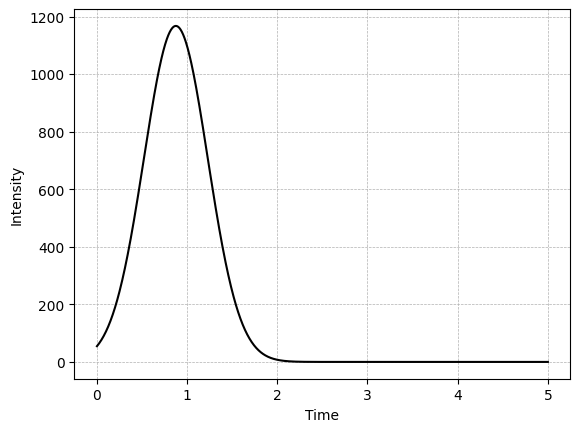

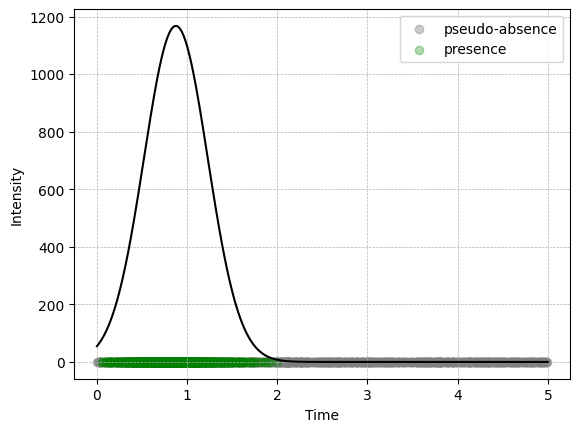

Number of presence: 1055
Number of absence: 1000


In [4]:
beta_true = np.array([4, 7, -4])
n0 = 1000
Z = 10000

X, y, t, z = generate_IPP(beta_true, n0, Z, verbose=True)

print(f"Number of presence: {len(y[y==1])}")
print(f"Number of absence: {n0}")


## ベイズ推定

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from   numpy.linalg import inv
import numpy.random as npr
from   pypolyagamma import PyPolyaGamma
from scipy.stats import multivariate_normal

# シグモイド関数
def sigmoid(x):
    """Numerically stable sigmoid function.
    """
    return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)),
                    np.exp(x) / (1 + np.exp(x)))

def multi_pgdraw(pg, B, C):
    """Utility function for calling `pgdraw` on every pair in vectors B, C.
    """
    return np.array([pg.pgdraw(b, c) for b, c in zip(B, C)])

In [6]:
# 平均ベクトルと共分散行列の設定
b = np.zeros(3)
B = np.diag(np.ones(3))

# Peform Gibbs sampling for T iterations.
pg         = PyPolyaGamma()
SIM          = 10000
beta_hat   = npr.multivariate_normal(b, B)
k          = y - z/2

beta_list = []
for _ in tqdm(range(SIM)):
    # ω ~ PG(1, x*β).
    Omega_diag = multi_pgdraw(pg, z, X @ beta_hat)
    # β ~ N(m, V).
    V         = inv(X.T @ np.diag(Omega_diag) @ X + inv(B))
    m         = np.dot(V, X.T @ k + inv(B) @ b)
    beta_hat  = npr.multivariate_normal(m, V)
    beta_list.append(beta_hat)
    
beta_list = np.array(beta_list)

 36%|███▌      | 3622/10000 [00:28<00:51, 125.02it/s]

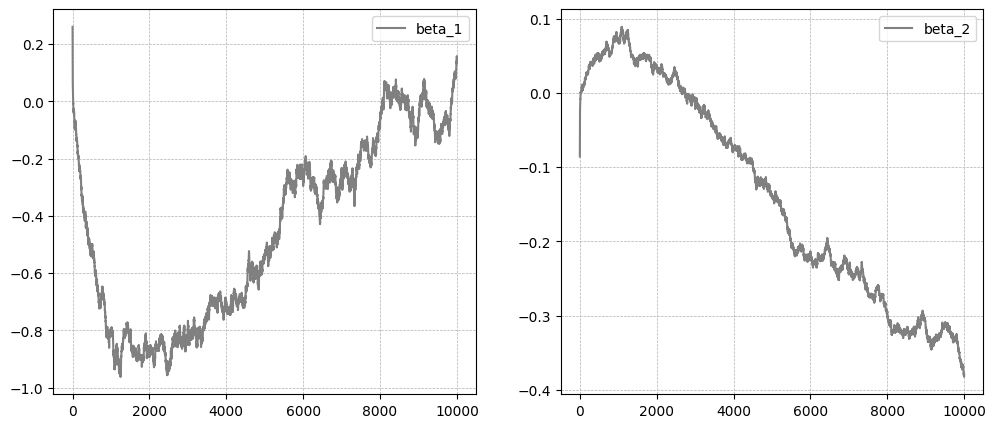

True beta: [ 4  7 -4]
MPE beta: [-7.76431109 -0.45537465 -0.13618311]


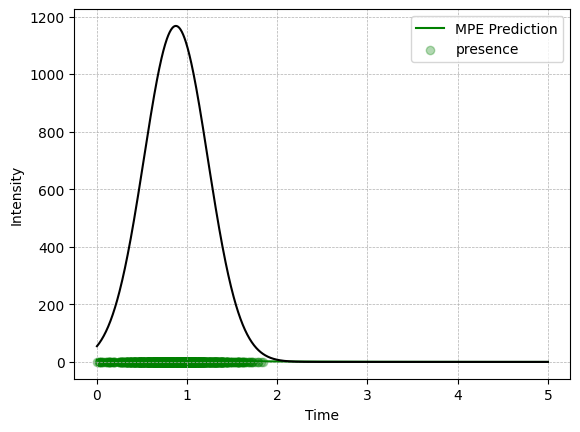

In [39]:
plt.figure(figsize=(12, 5))
#plt.title('Posterior Distribution of Beta')
# beta_list[:, 0]をTを横軸にしてプロット
plt.subplot(1, 2, 1)
plt.plot(beta_list[:, 1], c='grey', label='beta_1')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(beta_list[:, 2], c='grey', label='beta_2')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

beta_mpe = beta_list[15:].mean(axis=0)
print(f"True beta: {beta_true}")
print(f"MPE beta: {beta_mpe}")

# alpaだけは適当な値を設定
beta_mpe[0] = 2

x_lin = np.linspace(0, 5, 1000)
intensity = lamda(x_lin, beta_mpe)
plt.plot(x_lin, intensity, c='green', label='MPE Prediction')
plt.scatter(t[y==1], np.zeros(len(t[y==1])), c='green', alpha=0.3, label='presence')
plt.plot(x_lin, lamda(x_lin, beta_true), c='black')

plt.xlabel('Time')
plt.ylabel('Intensity')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


alphaの値が推定値にズレがあるのは織り込み済みだが、betaの値についても、過小推定されている。その理由はよくわからないが、しかし同時に、推定されたbetaの値をもとに強度関数を描いてみると、縦のスケールを無視すればそれなりに良い推定ができているとも言える。これはどうしてか。